# Machine Learning Comparison
In previous notebooks, we used a rule-based Information Extraction system to classify documents for TODO?? In this notebook, we'll use **Machine Learning** to classify the documents and then compare the two methods.

In [1]:
# import packages that we will need
from nlp_pneumonia_utils import read_doc_annotations
from DocumentClassifier import DocumentClassifier
from nlp_pneumonia_utils import list_errors
from visual import Vis
from visual import snippets_markup
from visual import view_pycontext_output
from visual import display_doc_text
# packages for interaction
from IPython.display import display, HTML
import ipywidgets

import sklearn

# Representing Text Data
We need to convert the raw text into a format that can be computed with. To do with, we'll be converting each document into a numerical vector using a **Bag of Words** model.

The idea behind a Bag of Words (BOW) model is simple: for each document, we'll jumble together all of the words in the document, not caring about the order they occurred in and represent the documents in a matrix. Each row will represent a document and each column will represent a word in our vocabulary. If a word is present in that document, that column will be 1. If it isn't, that column will be 0.

To get an intuition, here's a simple example: Suppose we have these 3 very short lower-cased documents:
1. "the dog ate."
2. "the cat sat."
3. "the cat sat on the dog."

In this example, we have a total of 7 words in our vocabulary:

V = {the, dog, ate, cat, sat, on, "."}

To represent this as a vector, here's what our matrix will look like:

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
import pandas as pd

In [3]:
def vectorize_documents(documents, vectorizer=None, ngrams=(1,1), min_df=1):
    if not vectorizer:
        vectorizer = CountVectorizer(tokenizer=word_tokenize, ngram_range=ngrams,
                                
                                     min_df=min_df, lowercase=False)
        X = vectorizer.fit_transform(documents)
    else:
        X = vectorizer.transform(documents)
    return X, vectorizer

def display_word_matrix(X, vectorizer, n=5):
    df = pd.DataFrame(X.todense())
    df.columns = vectorizer.get_feature_names()
    return df.head(n)

#vectorizer_example = CountVectorizer(tokenizer=word_tokenize)
example_docs = ["The dog ate.", "The cat sat.", "The cat sat on the dog."]
X_example, vectorizer_example = vectorize_documents(example_docs)
display_word_matrix(X_example, vectorizer_example)

,.,The,ate,cat,dog,on,sat,the
0,1,1,1,0,1,0,0,0
1,1,1,0,1,0,0,1,0
2,1,1,0,1,1,1,1,1


# Transform our dataset

In [4]:
# Read in data
from collections import Counter
def read_in_data():
    pos_doc_type='FAM_BREAST_CA_DOC'
    docs_train = read_doc_annotations(archive_file='data/bc_train.zip', pos_type=pos_doc_type)

    texts_train, labels_train = zip(*((doc.text, "Positive Document")
                          if doc.annotations[0].type == pos_doc_type
                          else (doc.text, "Negative Document") 
                          for doc in docs_train.values()))


    docs_test = read_doc_annotations(archive_file='img/bc_test.zip', pos_type=pos_doc_type)
    texts_test, labels_test = zip(*((doc.text, "Positive Document")
                          if doc.annotations[0].type == pos_doc_type
                          else (doc.text, "Negative Document") 
                          for doc in docs_test.values()))



    # texts += test_texts
    # labels += test_labels
    c_train = Counter(labels_train)
    c_test = Counter(labels_test)
    print()
    print("Number of positive training docs: {}".format(c_train["Positive Document"]))
    print("Number of negative training docs: {}".format(c_train["Negative Document"]))
    print()
    print("Number of positive testing docs: {}".format(c_test["Positive Document"]))
    print("Number of negative testing docs: {}".format(c_test["Negative Document"]))
    
    return texts_train, labels_train, texts_test, labels_test

In [5]:
texts_train, labels_train, texts_test, labels_test = read_in_data()

Reading annotations from file : data/bc_train.zip
Opening local file : data/bc_train.zip
Reading annotations from file : img/bc_test.zip
Opening local file : img/bc_test.zip

Number of positive training docs: 32
Number of negative training docs: 28

Number of positive testing docs: 22
Number of negative testing docs: 18


In [6]:
# Transform Data
X_train, vectorizer = vectorize_documents(texts_train)
X_test, _ = vectorize_documents(texts_test, vectorizer=vectorizer)
display_word_matrix(X_train, vectorizer)

,#,%,&,','','61,'80-'92,'d,'s,(,...,zyprexa,|,~10,~2,~200,~40,~5,~70K,~72,﻿Fort
0,14,4,0,0,0,0,0,0,3,47,...,0,0,0,0,0,0,0,0,0,0
1,0,3,0,0,0,0,0,0,0,13,...,0,0,0,0,0,0,0,0,0,0
2,5,7,2,0,1,0,0,0,12,52,...,0,0,0,0,0,0,0,0,0,0
3,1,7,0,0,1,0,0,0,7,12,...,0,0,0,0,0,0,0,0,0,0
4,13,1,3,0,0,0,0,1,6,24,...,0,0,0,0,0,0,0,0,0,0


# Naive approach
When you Google "Best machine learning algorithms", the first result Google suggests is `LogisticRegression`. So, let's try that!

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
# from sklearn.uti

clf = LogisticRegression()
clf.fit(X_train, labels_train)
pred = clf.predict(X_test)

print(classification_report(labels_test, pred, labels=["Positive Document"])) # Just look at scores for positive docs

                   precision    recall  f1-score   support

Positive Document       0.63      0.77      0.69        22

      avg / total       0.63      0.77      0.69        22



# Better approach
Our first attempt got a pretty low score: an F1 of TODO for predicting positive documents. This is much lower than the rule-based system that got an F1 of 0.821 

**TODO: Make sure that you're evaluating the same way**

But machine learning is rarely an "out-of-the-box" kind of task. A first try will rarely do well and there are plenty of tricks to improve our performance. We'll try a few of them right now and see if we can improve our performance.

1. **Data Clean-Up** - Looking at our features above, we can see a lot of useless information like punctuation, numbers, and very specific combinations of words that probably don't matter at all for our task. To address this, we'll convert our docuemnts to lower-case, use regular expressions to clean up the text a bit, and set a *document frequency threshold* of 0.2, which will restrict our vocabulary to words that occur in at least 20% of the documents. We'll also expand our features to look at bigrams and trigrams instead of just unigrams (words).
2. **Data** - A disadvantage of machine learning is that it typically requires a larger amount of data than manual, rule-based approaches. To maximize the amount of data that we can use, we're going to mix all of our data together and use *5-fold cross-validation* to train and evaluate on each data point, allowing us to use all of our data for both training and testing (importantly, without ever mixing them!)
3. **Different Models**: We just picked the first classifier we found on Google, but it's important to try lots of different algorithms and see if one works significantly better than the others.

In [10]:
# First, let's create one dataset for cross-validation.
texts = texts_train + texts_test
y = labels_train + labels_test
print("Total number of documents: {}".format(len(texts)))

Total number of documents: 100


In [19]:
# Data clean-up
import re

def preprocess(text):
    text = text.lower()
    # Remove punctuation, special symbols
    text = re.sub("[:./,%#()'\"&+-;<>@?]*", "", text)
    # Change any combination digits to be a special NUM symbol
    text = re.sub("[\d]+", "NUM", text)
    # Remove excess whitespace for human readability
    text = re.sub("[\n\s]+", " ", text)
    # Add additional code here
    ## 
    
    return text

In [20]:
print("****Before clean-up:****")
print(texts[0][:250])
print()
texts = [preprocess(text) for text in texts]
print("****After clean-up:****")
print(texts[0][:250])

****Before clean-up:****
 admission date discharge date date of birth sex f service medicine allergies aspirin attendingkhrystal chief complaint unwitnessed fall major surgical or invasive procedure egd history of present illness ms known patient lastname is a age over yo bl

****After clean-up:****
 admission date discharge date date of birth sex f service medicine allergies aspirin attendingkhrystal chief complaint unwitnessed fall major surgical or invasive procedure egd history of present illness ms known patient lastname is a age over yo bl


In [21]:
# Transform cleaned-up texts with an added document frequency `df`
X, vectorizer = vectorize_documents(texts, ngrams=(1,3), min_df=0.2)
display_word_matrix(X, vectorizer)

,a,a day,a history,a history of,a large,a left,a right,a small,a yearold,abd,...,would,x,xray,year,year old,yearold,years,years ago,yo,your
0,37,13,1,1,0,0,0,0,0,0,...,3,5,1,1,1,0,3,0,1,8
1,10,0,1,1,0,0,0,0,0,0,...,0,2,0,1,1,0,3,1,0,2
2,23,6,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,2,11
3,27,0,1,1,0,0,1,1,0,0,...,0,1,1,0,0,1,0,0,0,0
4,31,0,1,1,1,0,0,4,0,2,...,1,2,0,1,0,2,0,0,0,3


In [23]:
# Evaluate several classifiers using cross-validation
# Compae results

from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt

In [28]:
def evaluate_clfs(X, y, clfs):
    clf_names = []
    clf_scores = []
    for clf in clfs:
        model_name = clf.__repr__().split("(")[0]
        pred = cross_val_predict(clf, X, y, cv=3)
        clf_names.append(model_name)
        clf_scores.append(f1_score(y, pred, pos_label='Positive Document'))
    plot_results(clf_names, clf_scores)
    return clf_names, clf_scores

def plot_results(clf_names, clf_scores):
    x = range(len(clf_names))
    plt.plot(x, clf_scores, marker='.')
    plt.xticks(x, clf_names, rotation=45)
    plt.xlabel("Classifier Name")
    plt.ylabel("F1")
    return

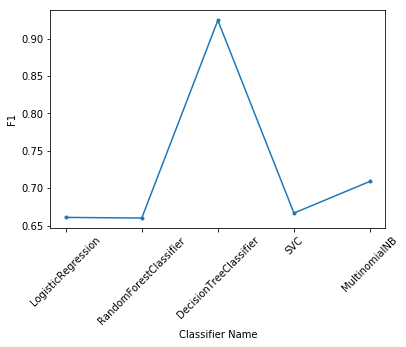

In [29]:
# Here are the classifiers we'll use
clfs = (LogisticRegression(), RandomForestClassifier(random_state=0), 
        DecisionTreeClassifier(random_state=0), SVC(), MultinomialNB())
clf_names, scores = evaluate_clfs(X, y, clfs)

Some of our steps clearly worked - The DecisionTreeClassifier got an F1 above 0.9, much higher than both our baseline LogisticRegression model and the rule-based system. Let's look at a more detailed analysis:

In [31]:
dtree = DecisionTreeClassifier()
pred = cross_val_predict(dtree, X, y)
print(classification_report(y, pred, labels=['Positive Document'])) # Just look at positive labels

                   precision    recall  f1-score   support

Positive Document       0.92      0.89      0.91        54

      avg / total       0.92      0.89      0.91        54



# Next Steps:
We tried a few things to improve our machine learning scores. Here are a few more steps we could take:
- **Data Clean-Up** - Remove stopwords, stem words, etc...
- **Hyperparameter Tuning** - Every machine learning model has hyperparameters that you can adjust. Pick a model and try training it with different hyperparameter combinations until you can find the best score.
- **CV** - Try different cross-validation partitions.
- **Feature Selection** - Try feature selection methods to reduce the number of features in our model

# Bonus: Visualizing Decision Tree Rules

In [32]:
# Retrain DT classifier using all of the data
from sklearn.model_selection import train_test_split
dtree = DecisionTreeClassifier(random_state=0)
dtree.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [33]:
def show_feature_importances(dtree, feature_names,n=10):
    importances = sorted(list(zip(feature_names, dtree.feature_importances_)), key=lambda x:x[1], reverse=True)
    return importances[:n]

In [34]:
feature_names = vectorizer.get_feature_names()

In [35]:
show_feature_importances(dtree, feature_names)

[('breast', 0.8088778282014997),
 ('over', 0.07693684022186438),
 ('persistent', 0.047863435544594955),
 ('extremities', 0.03948346339650693),
 ('transferred', 0.026838432635534083),
 ('a', 0.0),
 ('a day', 0.0),
 ('a history', 0.0),
 ('a history of', 0.0),
 ('a large', 0.0)]

In [36]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import collections


def visualize_tree(dtree, feature_names):
    dot_data = StringIO()
    export_graphviz(dtree, out_file=dot_data,  
                    filled=True, rounded=True,
                    feature_names=feature_names,
                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    return Image(graph.create_png())

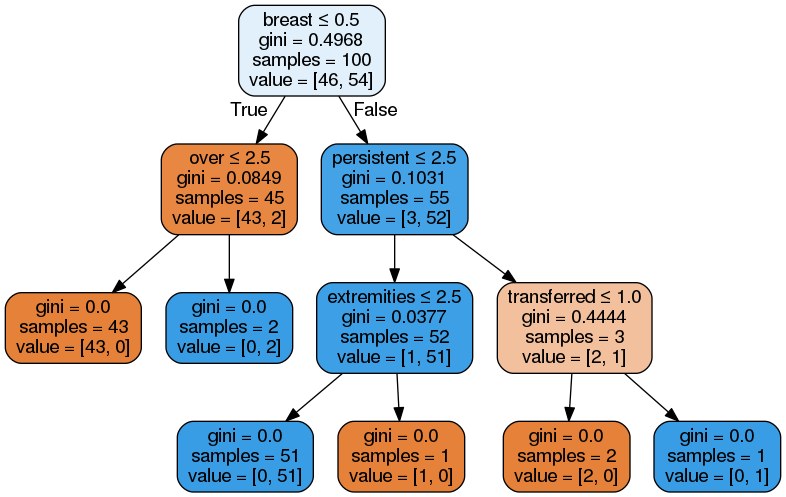

In [37]:
visualize_tree(dtree, feature_names)

# Interpretation
- Can you make sense of some of these rules?
- If not, do you think that's okay?
One disadvantage of machine learning is the "black box" where it is very difficult for a human to interpret/trust the results of an algorithm. It's important to work past this by going through the results like we did above. One next step you could take is to use the `display_doc_text` from the first notebook to look through some examples of documents and see if these rules make sense.

In [40]:
pos_doc_type='FAM_BREAST_CA_DOC'
annotated_doc_map = read_doc_annotations(archive_file='data/bc_train.zip', pos_type=pos_doc_type)
pos_docs=dict((k, v) for k, v in annotated_doc_map.items() if  v.annotations[0].type ==pos_doc_type)
neg_docs=dict((k, v) for k, v in annotated_doc_map.items() if  v.annotations[0].type !=pos_doc_type)

Reading annotations from file : data/bc_train.zip
Opening local file : data/bc_train.zip


In [41]:
display_doc_text(pos_docs)

interactive(children=(IntSlider(value=0, description='i', max=31), Output()), _dom_classes=('widget-interact',))

# Conclusion
Machine Learning offers alternatives to rule-based approaches for certain tasks like document classification. Both have advantages and disadvantages.

TODO: Add to this